# Deck prediction regression model

In [one of my projects](https://github.com/wlinds/card_wars) I simulated 32,000 battles between two fantasy card decks.

The gameplay is not very aesthetically pleasing. An example turn:

```
11:59:18.265 | game:end_turn:90 - Turn 5 ended.
11:59:18.265 | game:draw_card:285 - Player 1 drew: Wild Growth Mana cost: 0
11:59:18.265 | game:draw_card:281 - Player 2 drew: Bobblin The Goblin [4/3] Mana cost: 3
11:59:18.265 | game:play_card:216 - [+] Player 1 played: Grand Gnome [6/7] Mana: 5 Battlecry: Give a friendly minion +2/+2 and add a Frost Nova to your hand.
11:59:18.266 | game:check_battlecry:160 - Gnome received [+2/+2]
11:59:18.267 | game:check_battlecry:175 - Frost Nova added to P1's hand
11:59:18.267 | game:cast_spell:241 - Player 1 cast Wild Growth
11:59:18.267 | game:play_card:216 - [+] Player 2 played: Prince Gobb [5/5] Mana: 5 Battlecry: Give all friendly Goblin [+2/+2].
11:59:18.267 | game:check_battlecry:145 - Goblin Necromancer received [+2/+2] from Prince Gobb.
11:59:18.268 | card_wars.card:attack_target:67 - Gnome [3/3] attacks Goblin Necromancer [4/3]
11:59:18.268 | card_wars.card:take_damage:50 - Goblin Necromancer died while taking 3 damage.
11:59:18.268 | card_wars.card:take_damage:50 - Gnome died while taking 4 damage.
11:59:18.268 | game:remove_dead_minions:378 - Player 1's Gnome has died.
11:59:18.268 | game:remove_dead_minions:378 - Player 2's Goblin Necromancer has died.
11:59:18.269 | game:remove_dead_minions:389 - Goblin Necromancer triggered its deathrattle:
11:59:18.269 | board:add_to_field:138 - Goblin summoned to P2's field.
11:59:18.270 | card_wars.card:attack_target:67 - Prince Gobb [5/5] attacks Grand Gnome [6/7]
11:59:18.270 | card_wars.card:take_damage:52 - Grand Gnome took 5 damage. Now at 2 HP
11:59:18.270 | card_wars.card:take_damage:50 - Prince Gobb died while taking 6 damage.
11:59:18.271 | game:remove_dead_minions:378 - Player 2's Prince Gobb has died.
11:59:18.271 | game:attack_phase:316 - self.player1.health=26, self.player2.health=16
11:59:18.271 | game:end_turn:90 - Turn 6 ended.

However, it's incredibly fast to run simulations, making it a nice source for juicy data. I will try to construct a prediction model with it.

In [19]:
import pandas as pd
df = pd.read_csv("Data/goblin_vs_random_4_handle_spells_poorly_32k.csv")

In [20]:
df.head()

,generation,deck_uid,win_rate
0,0,ofpblwxzpyfiAjBEatsBaCEBmrndfg,0
1,0,BrjBAxvnyrwABarkyEnquwyervufrm,1
2,0,bErifojuftlxlyqovrnjtelxAxlvzl,1
3,0,pBmvyBjkwrbotbotwlzABnmrhzBCkf,1
4,0,BwhillkdaudjrfbiwpbDyhavarbDxc,3


## Data explanation & card game rules

Each character in the 'deck_uid' represent a unique Minion, Spell or Weapon card. In the simulation, any number of unique cards are randomly put together into a deck of 30 cards. The selected deck is then playing against a pre-determined opponent deck (Goblin synergy) with some randomizations for a total of 10 times, then a new deck_uid is generated.

Conditions:
- The decks are always shuffled before each simulation
- The players each start with three cards and continue to draw one card each turn until the deck has 0 cards. The player will then begin to take damage for each turn (1+n drawn fatigue cards)
- Each player start with 30 health and 1 mana. The player gains 1 additional mana each turn until the limit of 10 mana is reached.
- The game ends when a player reaches 0 health. If the test deck wins, they will receive 1 point. The best performing deck can only ever get 10 points. The worst performing 0 points.

Player logic:
- The player logic is... bad.
- Each player will try to play any card from left to right in its hand. As long as the player have the mana for it, they will play it.
- Cards that targets other minions or players are... semi-intelligent.

In [21]:
df = df.drop(['generation'], axis=1) # No mutations are performed in this dataset, we drop that column.

It doesn't really matter, but I want to sort the uids.

In [22]:
def sort_strings(s):
    return ''.join(sorted(s))

df['sorted_uid'] = df['deck_uid'].apply(sort_strings)

In [23]:
df = df.drop(['deck_uid'], axis=1)

win_rate
0     1050
1      886
2      614
3      312
4      194
5       81
6       44
7       13
8        3
9        2
10       1
Name: count, dtype: int64


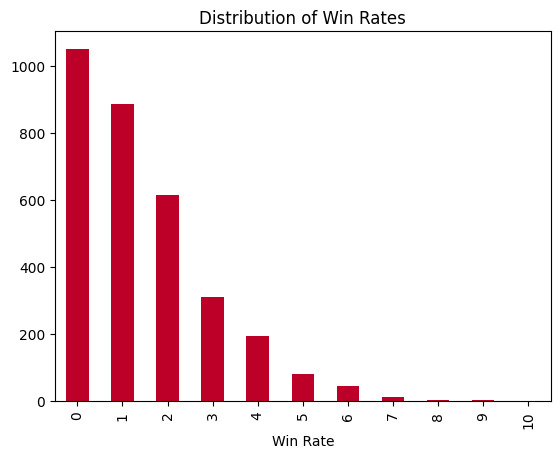

In [24]:
import matplotlib.pyplot as plt

print(df['win_rate'].value_counts())

df['win_rate'].value_counts().sort_index().plot(kind='bar', color='#bc0028')
plt.xlabel('Win Rate')
plt.title('Distribution of Win Rates')
plt.show()

The average deck performed *embarrassingly* bad. It's likely due to the opponent deck having card synergy and a decent mana curve, while the test deck itself is completely random.


## Count Encoding / Frequency Encoding

Kind of like one-hot encoding, except, well, counting the "hots".

In [25]:
unique_chars = sorted(set(''.join(df['sorted_uid'])))

for char in unique_chars:
    df[char] = df['sorted_uid'].apply(lambda x: x.count(char))

df

,win_rate,sorted_uid,A,B,C,D,E,a,b,c,...,q,r,s,t,u,v,w,x,y,z
0,0,ABBBCEEaabdfffgijlmnopprstwxyz,1,3,1,0,2,2,1,0,...,0,1,1,1,0,0,1,1,1,1
1,1,AABBBEaefjkmnnqrrrrruuvvwwxyyy,2,3,0,0,1,1,0,0,...,1,5,0,0,2,2,2,1,3,0
2,1,AEbeffijjlllllnooqrrttuvvxxxyz,1,0,0,0,1,0,1,0,...,1,2,0,2,1,2,0,3,1,1
3,1,ABBBBCbbfhjkklmmnooprrttvwwyzz,1,4,1,0,0,0,2,0,...,0,2,0,2,0,1,2,0,1,2
4,3,BDDaaabbbcddfhhiijkllprruvwwxy,0,1,0,2,0,3,3,1,...,0,2,0,0,1,1,2,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,2,AABDEEEEabbcfijklmpppprsssswxy,2,1,0,1,4,1,2,1,...,0,1,4,0,0,0,1,1,1,0
3196,1,AAAABCCDadeeghijllmpqrrsswwyyz,4,1,2,1,0,1,0,0,...,1,2,2,0,0,0,2,0,2,1
3197,1,ACDDEEaabcegiijjlmnooooptvwwwx,1,0,1,2,2,2,1,1,...,0,0,0,1,0,1,3,1,0,0
3198,0,AABCDEabehhijkmmpqrrsttuvwyzzz,2,1,1,1,1,1,1,0,...,1,2,1,2,1,1,1,0,1,3


## Standardization and Train|Test split

In [26]:
from sklearn.model_selection import train_test_split

X = df.drop(['win_rate', 'sorted_uid'], axis=1) # Drop win rate and uid, only keep count encoding
y = df['win_rate'] # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
from sklearn.preprocessing import StandardScaler

# Feature standardization is not really useful on this data (?), but we'll test it anyway
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

X_train_scaled = X_train
X_test_scaled = X_test

## Keras model

In [28]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(16, activation='relu'))

model.add(Dense(1, activation='linear'))  # Regression
# If we had a binary classification (win/lose) we'd use sigmoid.
# If we had multi-class classification we'd use soft-max.

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test))

Epoch 1/50


80/80 [==============================] - 2s 6ms/step - loss: 2.4043 - val_loss: 2.0323
Epoch 2/50
80/80 [==============================] - 0s 2ms/step - loss: 1.6211 - val_loss: 1.6722
Epoch 3/50
80/80 [==============================] - 0s 2ms/step - loss: 1.3545 - val_loss: 1.5410
Epoch 4/50
80/80 [==============================] - 0s 2ms/step - loss: 1.2737 - val_loss: 1.5119
Epoch 5/50
80/80 [==============================] - 0s 2ms/step - loss: 1.2415 - val_loss: 1.4942
Epoch 6/50
80/80 [==============================] - 0s 2ms/step - loss: 1.2106 - val_loss: 1.4810
Epoch 7/50
80/80 [==============================] - 0s 2ms/step - loss: 1.1896 - val_loss: 1.4756
Epoch 8/50
80/80 [==============================] - 0s 2ms/step - loss: 1.1812 - val_loss: 1.4725
Epoch 9/50
80/80 [==============================] - 0s 2ms/step - loss: 1.1579 - val_loss: 1.4709
Epoch 10/50
80/80 [==============================] - 0s 2ms/step - loss: 1.1383 - val_loss: 1.4600
Epoch 11/50
80/80 [===========

## Eval

In [29]:
loss = model.evaluate(X_test_scaled, y_test)
print(f'Mean Squared Error on Test Set: {loss}')

20/20 [==============================] - 0s 1ms/step - loss: 1.6156
Mean Squared Error on Test Set: 1.615558385848999


Mean Squared Error on Test Set: 1.692472815513610 (Standardization)<br>
Mean Squared Error on Test Set: 1.615558385848999 (No standardization)


20/20 [==============================] - 0s 1ms/step
Mean Squared Error on Test Set: 1.6155584767483344


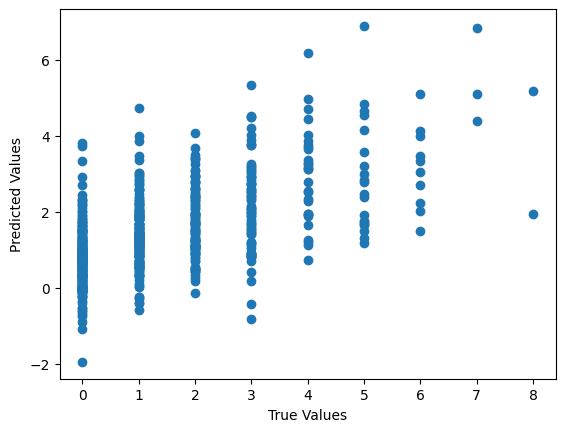

In [31]:
predictions = model.predict(X_test_scaled)
# 'predictions' now contains the predicted values for each instance in X_test_scaled

# The model is trained for a regression task (linear activation in the output layer)
# so we can directly compare the predicted values with the actual labels (y_test)

from sklearn.metrics import mean_squared_error

# MSE between predicted and actual values
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error on Test Set: {mse}')

plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

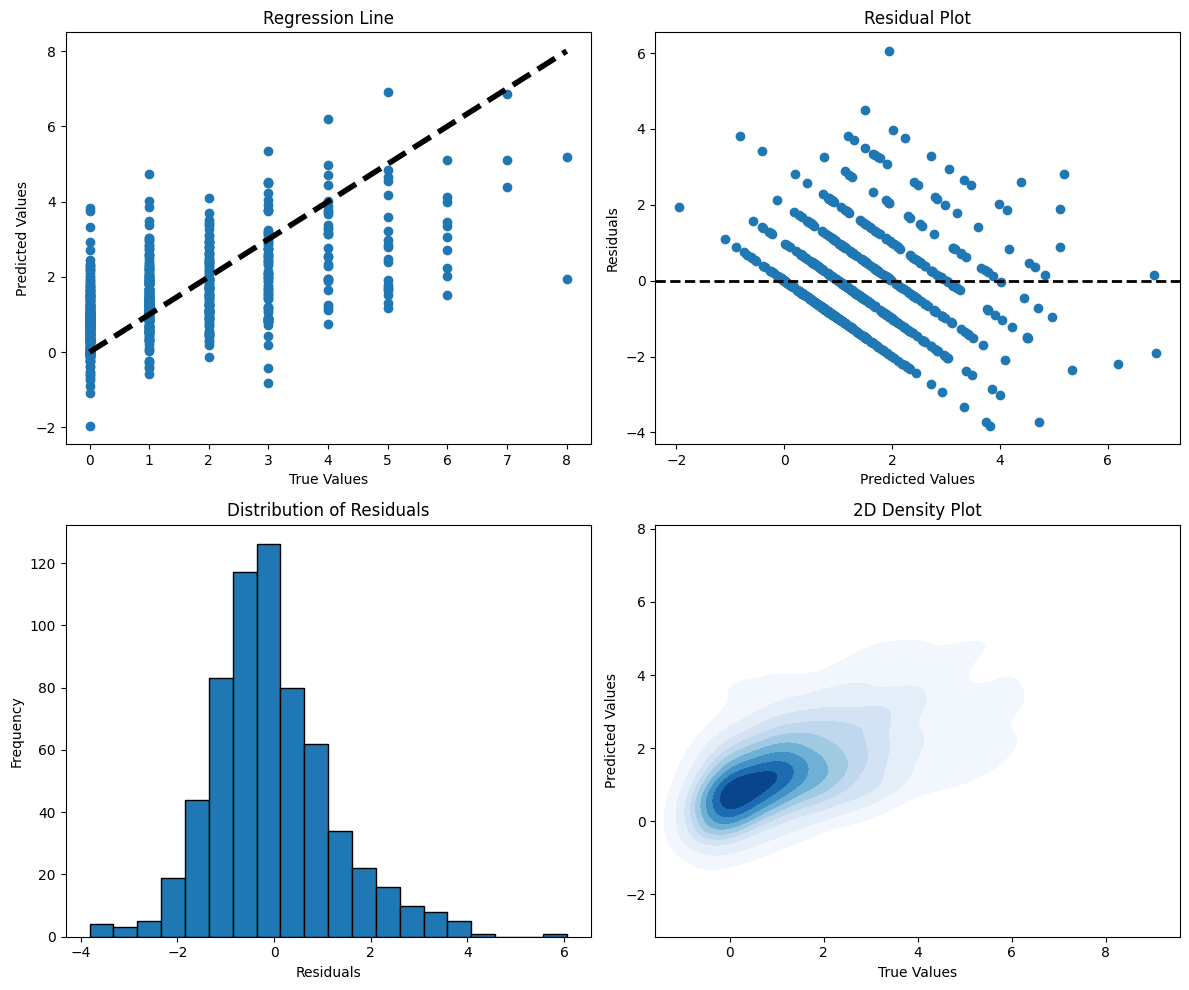

In [42]:
import seaborn as sns

residuals = y_test - predictions.flatten()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Scatter plot of true values vs predicted values
axes[0, 0].scatter(y_test, predictions)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
axes[0, 0].set_xlabel('True Values')
axes[0, 0].set_ylabel('Predicted Values')
axes[0, 0].set_title('Regression Line')

# Residual plot
axes[0, 1].scatter(predictions, residuals)
axes[0, 1].axhline(y=0, color='black', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Predicted Values')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residual Plot')

# Distribution of residuals
axes[1, 0].hist(residuals, bins=20, edgecolor='black')
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Residuals')

# Density Plot
sns.kdeplot(x=y_test, y=predictions.flatten(), cmap='Blues', fill=True, ax=axes[1, 1])
axes[1, 1].set_xlabel('True Values')
axes[1, 1].set_ylabel('Predicted Values')
axes[1, 1].set_title('2D Density Plot')

plt.tight_layout()
plt.show()


I mean, it's not good. But it ain't *that* bad. Since we had the an overwhelmingly amount of sample points for bad performing decks (0 wins/10 games), it makes sense that the model is better at predicting poor decks. However we cannot predict less than 0 for a deck. This needs to be addressed. One solution is to clip the predictions:
```np.clip(predictions, 0, 1)```, but there must be a better way to do this.

---

## Prediction on new decks

Now when the player is constructing a deck, we can give a hint of how well the deck is expected to perform.

In [53]:
# First we decode our count encoded data (this could have been avoided by storing the sorted_uid before popping it from X during the train|test split...)

def decode_deck_uid(encoded_deck_uid, unique_chars):
    decoded_deck_uid = ''
    for char, count in zip(unique_chars, encoded_deck_uid):
        decoded_deck_uid += char * count
    return decoded_deck_uid


encoded_deck_uid = X_test.iloc[0]
decoded_deck_uid = decode_deck_uid(encoded_deck_uid, unique_chars)
decoded_deck_uid

'ACEaabbcddfhikkkkllmmnoqrsuvwy'

This decoder allows us to test any deck string (serialized through DeckSerializer in [card_wars/deck.py](https://github.com/wlinds/card_wars/blob/main/src/card_wars/deck.py))

In [54]:
import numpy as np

input_deck_uid = "ACEaabbcddfhikkkkllmmnoqrsuvwy"
encoded_input = [input_deck_uid.count(char) for char in unique_chars]

# Reshape the input to have shape (1, num_features)
reshape_input = np.reshape(encoded_input, (1, -1))

predicted_win_rate = model.predict(reshape_input)
print(f'Predicted Win Rate: {predicted_win_rate[0][0]}')

1/1 [==============================] - 0s 25ms/step
Predicted Win Rate: 2.516423463821411


Predicted 2.5 wins / 10 games. Let's check the ground truth.

In [56]:
df[df['sorted_uid'] == "ACEaabbcddfhikkkkllmmnoqrsuvwy"]

,win_rate,sorted_uid,A,B,C,D,E,a,b,c,...,q,r,s,t,u,v,w,x,y,z
2384,3,ACEaabbcddfhikkkkllmmnoqrsuvwy,1,0,1,0,1,2,2,1,...,1,1,1,0,1,1,1,0,1,0


That's accurate enough to me!

Of course the model can be improved by a lot, but I'd rather collect some new data and run it through the NN first.

### TODO:s for next simulation / data collection

Card improvements:
- The pool of cards should be expanded. More high cost cards, more diverse, more synergy.

Card limitations:
- Players are only allowed a maxmimum of 2 unique cards in each deck.

Logic improvements:
- Improved player logic and targeting. (Improved TargetAssist)
- Eventually implement some kind of reinforcement learning for player actions, that would be dope. (But that's for another model.)